In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy import stats
import math
from tqdm import tqdm
import seaborn as sns
import umap
from multiprocessing import freeze_support
import mordred
from mordred import Calculator, descriptors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
import rdkit
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
randomstate = 42

# Structure generation

- Import smiles from an excel file, remove duplicates
- Embed 3D structure from smiles, optimize with MMFF (UFF also possible). MMFF optimization will give significantly different values. Sometimes give errors due to bad conformer id: just run it again if only a small list of molecules, comment out this line if its a big list
- http://rdkit.org/docs/GettingStartedInPython.html - "Working with 3D Molecules"
- https://chemistry.stackexchange.com/questions/118460/is-it-possible-to-build-or-embed-the-smiles-representation-of-compounds-in-3d

In [2]:
mols = pd.read_excel('smiles.xlsx',engine='openpyxl')
print('Number of SMILES:',len(mols))

mols = mols.drop_duplicates(subset=['smiles'])                         # drop duplicates based on smiles

mols['rdmol'] = mols['smiles'].map(lambda x: Chem.MolFromSmiles(x))    # drop duplicates based on inchi
mols['inchi'] = mols['rdmol'].map(Chem.MolToInchi)
mols = mols.drop_duplicates(subset="inchi")

print('Number of SMILES after duplicates removed:',len(mols))

mols

Number of SMILES: 100
Number of SMILES after duplicates removed: 99


,smiles,rdmol,inchi
0,CC(C)Oc1ccc(Cl)cc1B(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H12BClO3/c1-6(2)14-9-4-3-7(11)5-8(9...
1,Cc1cc(B(O)O)c(C)cc1F,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C8H10BFO2/c1-5-4-8(10)6(2)3-7(5)9(11)...
2,CC1(C)OB(c2ccc(F)cc2)OC1(C)C,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C12H16BFO2/c1-11(2)12(3,4)16-13(15-11..."
3,CC(C)(C)OC(=O)n1cccc1B1OC(C)(C)C(C)(C)O1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C15H24BNO4/c1-13(2,3)19-12(18)17-10-8..."
4,OB(O)c1ccc(Oc2ccccc2)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C12H11BO3/c14-13(15)10-6-8-12(9-7-10)...
...,...,...,...
94,COc1ccc(C(F)(F)F)cc1B(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C8H8BF3O3/c1-15-7-3-2-5(8(10,11)12)4-..."
95,CC(C)(C)c1cccc(B(O)O)c1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C10H15BO2/c1-10(2,3)8-5-4-6-9(7-8)11(..."
96,Cc1ccsc1B1OC(C)(C)C(C)(C)O1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C11H17BO2S/c1-8-6-7-15-9(8)12-13-10(2...
97,OB(O)c1cc(Cl)ncc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C5H4BCl2NO2/c7-4-2-9-5(8)1-3(4)6(10)1...


In [3]:
def embed(mol):
    mol_with_H = Chem.AddHs(mol)
    Chem.AllChem.EmbedMolecule(mol_with_H)
    Chem.AllChem.MMFFOptimizeMolecule(mol_with_H)
    return mol_with_H

mols['rdmol_optimized'] = mols.rdmol.map(embed)

mols

,smiles,rdmol,inchi,rdmol_optimized
0,CC(C)Oc1ccc(Cl)cc1B(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C9H12BClO3/c1-6(2)14-9-4-3-7(11)5-8(9...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,Cc1cc(B(O)O)c(C)cc1F,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C8H10BFO2/c1-5-4-8(10)6(2)3-7(5)9(11)...,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CC1(C)OB(c2ccc(F)cc2)OC1(C)C,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C12H16BFO2/c1-11(2)12(3,4)16-13(15-11...","<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC(C)(C)OC(=O)n1cccc1B1OC(C)(C)C(C)(C)O1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C15H24BNO4/c1-13(2,3)19-12(18)17-10-8...","<img data-content=""rdkit/molecule"" src=""data:i..."
4,OB(O)c1ccc(Oc2ccccc2)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C12H11BO3/c14-13(15)10-6-8-12(9-7-10)...,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...
94,COc1ccc(C(F)(F)F)cc1B(O)O,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C8H8BF3O3/c1-15-7-3-2-5(8(10,11)12)4-...","<img data-content=""rdkit/molecule"" src=""data:i..."
95,CC(C)(C)c1cccc(B(O)O)c1,"<img data-content=""rdkit/molecule"" src=""data:i...","InChI=1S/C10H15BO2/c1-10(2,3)8-5-4-6-9(7-8)11(...","<img data-content=""rdkit/molecule"" src=""data:i..."
96,Cc1ccsc1B1OC(C)(C)C(C)(C)O1,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C11H17BO2S/c1-8-6-7-15-9(8)12-13-10(2...,"<img data-content=""rdkit/molecule"" src=""data:i..."
97,OB(O)c1cc(Cl)ncc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",InChI=1S/C5H4BCl2NO2/c7-4-2-9-5(8)1-3(4)6(10)1...,"<img data-content=""rdkit/molecule"" src=""data:i..."


# Calculate Mordred descriptors

List of descriptors = https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [4]:
calc = Calculator(descriptors) # create calculator for all mordred descriptors (can also specify subtype)

df=calc.pandas(mols['rdmol_optimized'])
print(df)

100%|██████████| 99/99 [00:14<00:00,  6.71it/s]

          ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0   10.365564   9.738246      0      0  16.426384  2.337335  4.674671   
1    8.910910   8.583028      0      0  14.004903  2.346955  4.693910   
2   12.630705  11.241455      0      0  18.896779  2.508655  4.811430   
3   16.562115  15.535186      0      0  23.740263  2.529970  4.832745   
4   12.199155   9.978922      0      0  20.509223  2.288246  4.576491   
..        ...        ...    ...    ...        ...       ...       ...   
94  11.159647  10.580386      0      0  17.416966  2.389261  4.778521   
95   9.785874   9.203562      0      0  14.978073  2.344507  4.689013   
96  11.883158  11.470630      0      0  17.645288  2.519531  4.822306   
97   8.134854   7.808786      0      0  13.132593  2.305040  4.610080   
98   8.732571   8.355757      0      0  14.414901  2.309323  4.618646   

       SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0   16.426384  1.173313  3.526972  ...   9.2991

Replace mordred errors with NaNs then drop those descriptors/columns

In [5]:
df=df.applymap(lambda x: np.nan if type(x) in [mordred.error.Missing,mordred.error.Error] else x)
df=df.dropna(axis=1)
print(df.shape)

(99, 1549)


Drop columns that have a single value

In [6]:
non_zero_std = df.std() != 0
df = df [non_zero_std[non_zero_std].index]
print(df.shape)

(99, 1330)


Drop highly correlated descriptors: If a pair of descriptors have a Pearson correlation coefficient (r) value greater than the threshold then one descriptor will be removed.

In [7]:
threshold=0.95
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)
print(df.shape)

(99, 611)


Save the excel

In [8]:
to_save=pd.concat([mols[['smiles']], df], axis=1)
to_save

,smiles,ABC,nAcid,nBase,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,...,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex
0,CC(C)Oc1ccc(Cl)cc1B(O)O,10.365564,0,0,2.337335,4.674671,1.173313,3.353025,60.812193,6,...,0.081871,0.059028,0.059608,0.037202,0.023090,0.000000,0.000000,0.000000,0.000000,0.750000
1,Cc1cc(B(O)O)c(C)cc1F,8.910910,0,0,2.346955,4.693910,1.167075,3.202596,42.402376,6,...,0.117647,0.066176,0.070370,0.039352,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,CC1(C)OB(c2ccc(F)cc2)OC1(C)C,12.630705,0,0,2.508655,4.811430,1.181049,3.434343,104.214302,6,...,0.131687,0.064444,0.068016,0.044926,0.018371,0.046155,0.000000,0.000000,0.000000,1.000000
3,CC(C)(C)OC(=O)n1cccc1B1OC(C)(C)C(C)(C)O1,16.562115,0,0,2.529970,4.832745,1.130489,3.816131,179.171886,5,...,0.117284,0.075521,0.052500,0.039095,0.036659,0.010364,0.039005,0.000000,0.000000,0.800000
4,OB(O)c1ccc(Oc2ccccc2)cc1,12.199155,0,0,2.288246,4.576491,1.281826,3.724763,78.586156,12,...,0.060606,0.034375,0.038222,0.019231,0.014545,0.021701,0.012346,0.008875,0.012346,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,COc1ccc(C(F)(F)F)cc1B(O)O,11.159647,0,0,2.389261,4.778521,1.161131,3.514755,62.504325,6,...,0.111111,0.059659,0.055439,0.062500,0.012245,0.000000,0.000000,0.000000,0.000000,0.750000
95,CC(C)(C)c1cccc(B(O)O)c1,9.785874,0,0,2.344507,4.689013,1.152159,3.323177,49.074506,6,...,0.105263,0.058824,0.052308,0.064583,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
96,Cc1ccsc1B1OC(C)(C)C(C)(C)O1,11.883158,0,0,2.519531,4.822306,1.176353,3.476923,72.699129,5,...,0.136752,0.080918,0.058571,0.053333,0.018519,0.000000,0.000000,0.000000,0.000000,1.000000
97,OB(O)c1cc(Cl)ncc1Cl,8.134854,0,0,2.305040,4.610080,1.193872,3.089123,37.182651,6,...,0.103704,0.066964,0.065333,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667


In [ ]:
to_save.to_excel('mordred_descriptors.xlsx', index = True)

# PCA and K-means clustering

Test the descriptors. If an error due to NaN arises, go to section 4.

In [9]:
df.index = df.index.astype(int)
df.dropna(axis=0,inplace=True)
X_all = np.array(df)
X_all_ids = np.array(df.index)
scaler = StandardScaler()
scaler.fit(X_all)
X_all_sc = scaler.transform(X_all)

pca = PCA(n_components=10)     # choose number of PCs

pca.fit(X_all_sc)
X_all_pca    = pca.transform(X_all_sc)
pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
print('Variance explained by individual PCs:',np.around(pca.explained_variance_ratio_, decimals=2),'\n')
print('Total variance explained by PCs:',np.around(np.sum(pca.explained_variance_ratio_), decimals=2))

Variance explained by individual PCs: [0.24 0.12 0.08 0.05 0.04 0.04 0.03 0.03 0.03 0.02] 

Total variance explained by PCs: 0.69


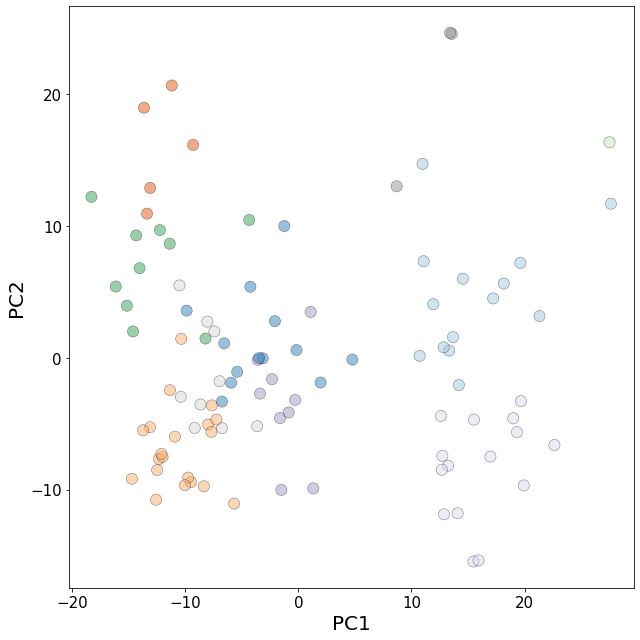

In [10]:
nclusters = 10     # choose number of clusters

####################################################################################

X_use = X_all_pca
X_main_ids = X_all_ids
X_kmeans = X_all_pca
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(X_kmeans)
dists = []
for x in range(len(X_kmeans)):
    delta = [X_kmeans[x,i]-kmeans.cluster_centers_[kmeans.labels_[x],i] for i in range(len(X_kmeans[0]))]
    dist = np.linalg.norm(delta)
    dists.append(dist)
clusters = {}
clusterdists = {}
clustermins = []
clusterorders_dict = {}
clusterorders = np.zeros(X_kmeans.shape[0])
for x in range(nclusters):
    clusters[x] = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == x]
    clusterdists[x] = [dists[i] for i in clusters[x]]
    clustermins.append(clusters[x][clusterdists[x].index(min(clusterdists[x]))])
    clusterorders_dict[x] = [y for _,y in sorted(zip(clusterdists[x],clusters[x]))]
    for i in clusters[x]:
        clusterorders[i] = clusterorders_dict[x].index(i)+1
f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = X_kmeans[:, f_ind_1].min() - 2, X_kmeans[:, f_ind_1].max() + 2
y_min, y_max = X_kmeans[:, f_ind_2].min() - 2, X_kmeans[:, f_ind_2].max() + 2
plt.figure(figsize=(9,9))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(r"PC1",fontsize=20)
plt.ylabel(r"PC2",fontsize=20)
plt.locator_params(axis='y', nbins=8)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
mapping = kmeans.labels_
cMap = "tab20c"
plt.scatter(X_kmeans[:,f_ind_1], X_kmeans[:,f_ind_2],c=mapping,cmap=cMap,alpha=.5,marker=".",s=500,edgecolor="black",linewidth=0.5)
main_row_id = list(enumerate(X_main_ids))
clusters_with_ids = {}
for i in range(0,len(clusters)):
    emptylist = []
    for j in range(0,len(clusters[i])):
        emptylist.append(main_row_id[clusters[i][j]][1])
    clusters_with_ids[i] = emptylist
    
### plot ligand ids    
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="blue",fontsize=12,ha="left")

### plot centroid labels
#for i in range(0,nclusters):
#    for j in range(0,len(clusters_with_ids[i])):
#        if clusters[i][j] in clustermins:
#            plt.text(X_use[clusters[i][j],f_ind_1],X_use[clusters[i][j],f_ind_2]," "+str(clusters_with_ids[i][j]),color="red",fontsize=13,ha="right")
    
plt.tight_layout()
#plt.savefig("mordred_pca_plot.png",dpi=300)
plt.show()     

Print structures closest to the cluster centroids

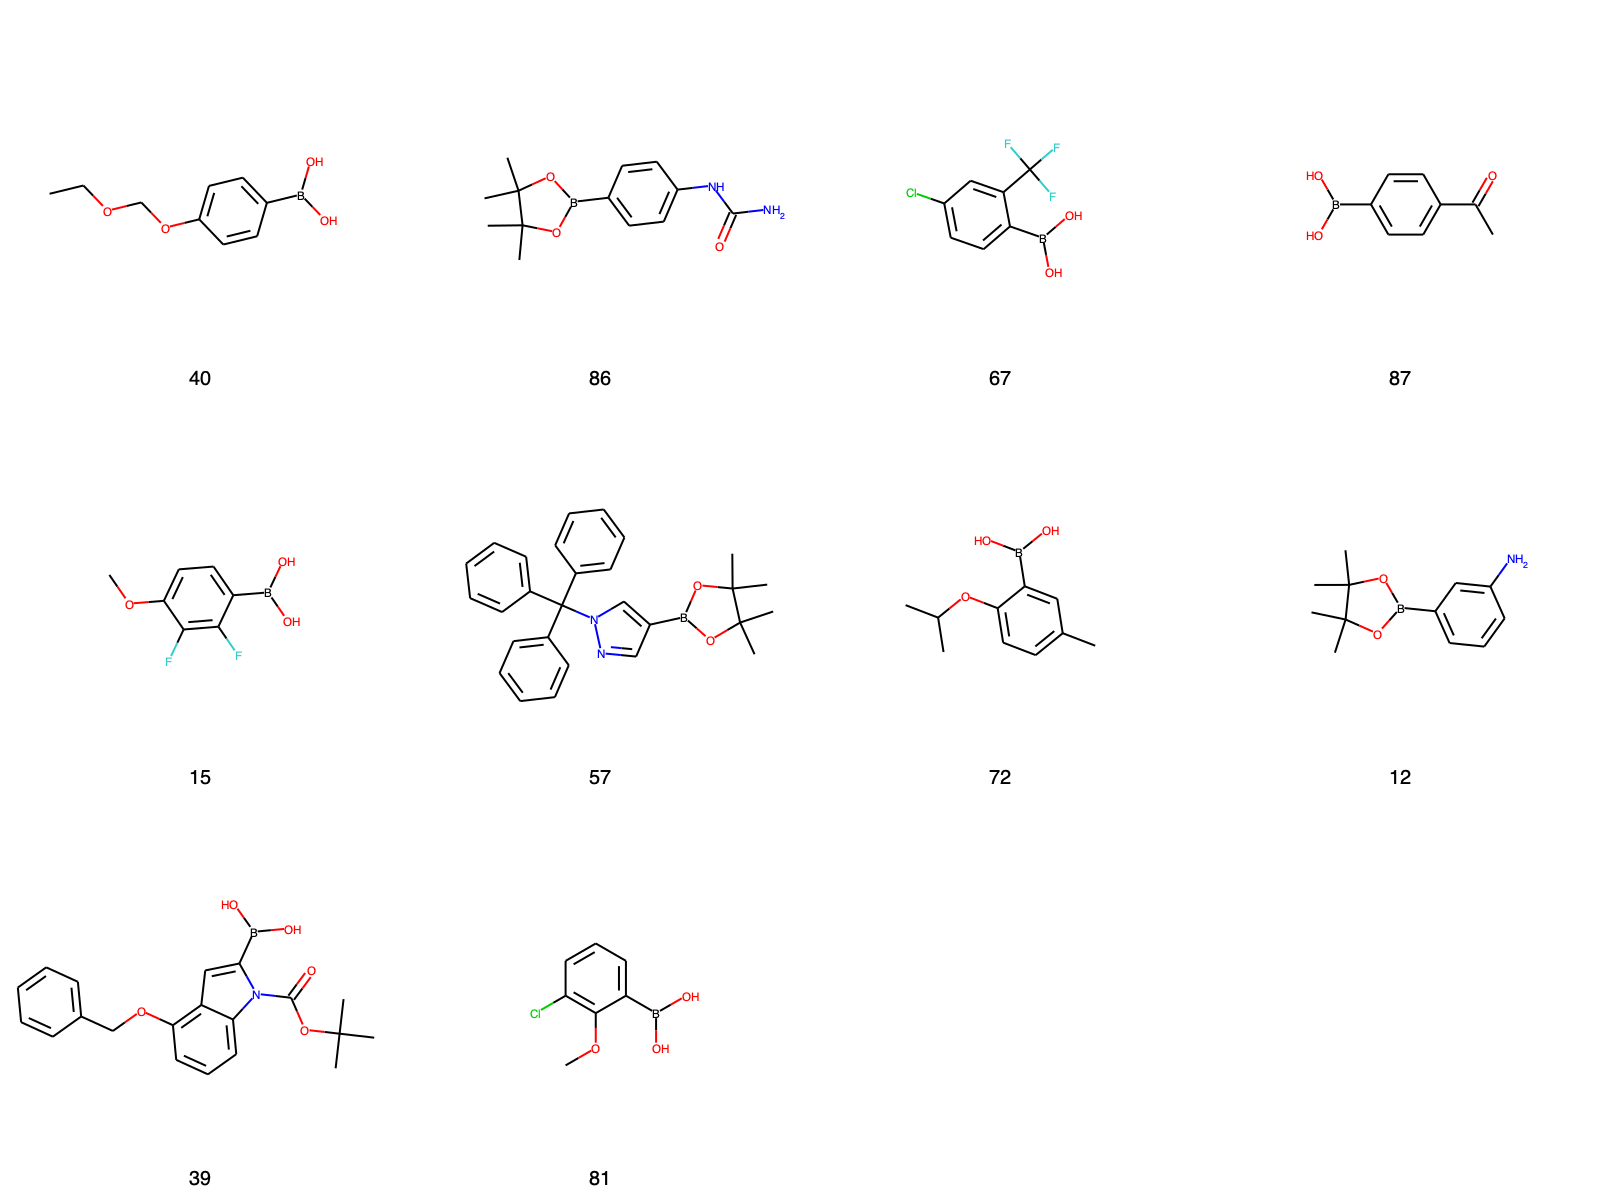

In [11]:
smiles = list(mols['smiles'])

closest_to_centroids = []
for i in clustermins:
    closest_to_centroids.append(smiles[i])

count=0
subms = []
for i in closest_to_centroids:
    x = Chem.MolFromSmiles(i)
    count+=1
    subms.append(x)
clustermins_str = [str(i) for i in clustermins]
my_labels = clustermins_str  
molsPerRow = 4
subImgSize= (400,400)
nRows = -(count // -molsPerRow)
fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
img = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1],subImgSize[0], subImgSize[1]) # setting up the image
img.drawOptions().legendFontSize=20
img.DrawMolecules(subms[:],legends=my_labels[:])
img.SetFontSize(100)
img.FinishDrawing()

with open('centroids.png','wb+') as wfp:      # opening a png file, goes into current folder
    wfp.write(img.GetDrawingText())           # saving in the image
Image.open('centroids.png')                   # opening it in the notebook

# Finding other NaNs in X_all_sc

Find descriptors with bad sample values

In [ ]:
for i in range(0,len(X_all_sc)):
    if np.isnan(X_all_sc[i]).any():
        for j in range(0,len(X_all_sc[i])):
            if np.isnan(X_all_sc[i][j]):
                print('sample',i,'contains NaN for descriptor',j)

Find samples with bad descriptor values (Jordan's code)

In [ ]:
problem_samples = []
for i in range(0,len(X_all_sc)):
    if np.isnan(X_all_sc[i]).any():
        for j in range(0,len(X_all_sc[i])):
            if np.isnan(X_all_sc[i][j]):
                problem_samples.append(i)
                #print('sample',i,'contains NaN for descriptor',j)
unique_problem_samples = []
for i in problem_samples:
    if i not in unique_problem_samples:
        unique_problem_samples.append(i)
    else:
        pass
print("Problematic samples that will be removed are: " + str(unique_problem_samples))
df_with_deleted_rows = df2.drop(unique_problem_samples)
df_with_deleted_rows.to_excel(r'arylboronicacid_desc_test.xlsx', index = True)
#The above code gives a new excel sheet with molecules with NaNs removed.
print(problem_samples)

Produce a new excel sheet with all the smiles strings corresponding to molecules with NaNs removed.

In [ ]:
trimmed_smiles = []
for i in range(len(smiles)):
    if i not in unique_problem_samples:
        trimmed_smiles.append(smiles[i])
        print(smiles[i])
        #The printed smiles strings can be copied into excel directly
    else:
        pass

print("unaltered smiles list was ", len(smiles), " entries long.")
print("altered smiles list was ", len(trimmed_smiles), " entries long.")
